In [41]:
import matplotlib.pyplot as plt
import nibabel as nib
import pandas as pd
import numpy as np
from tqdm import trange
import scipy.io 
import mne
import os
import sys
psi_out_path = r"/Users/madwoman/Desktop/tpp_seeg/psi_out/insula_amygdala_BGA_kids/"
os.makedirs(psi_out_path, exist_ok=True)  # 如果路径不存在，则创建

# in_roi1_path = r"E:/workspace/sEEG_slow_fast_attack/roi_data_true/vmpfc/" # 分析哪个roi就输入哪个文件夹的数据
in_roi1_path = r"/Users/madwoman/Desktop/tpp_seeg/roi_data_1234_kids/insula/"# 分析哪个roi就输入哪个文件夹的数据
in_roi2_path = r"/Users/madwoman/Desktop/tpp_seeg/roi_data_1234/amygdala_new/" # 分析哪个roi就输入哪个文件夹的数据
in_roi1_baseline = r"/Users/madwoman/Desktop/tpp_seeg/roi_data_baseline/insula/" 
in_roi2_baseline = r"/Users/madwoman/Desktop/tpp_seeg/roi_data_baseline/amygdala_new/" 

roi_name = "vmpfc-insula"
# time_lag = np.arange(-0.3, 0.31, 0.01)
# subjects = [119, 125, 127]  # vmpfc*amy/ins for kids 

# subjects = [108, 116, 117, 120, 122, 135]  # 同时有 vmpfc 和 insula (120)/amy  

# subjects = [108, 112, 113, 116, 117, 122, 130, 135]  # insula 和 amy  
subjects = [110, 119, 124, 125, 127, 131, 134] # amy* insula for kids

# subjects = [108, 116, 117, 120, 122, 135] # vmpfc  
# subjects = [119, 125, 127] # vmpfc for kids 
# subjects = [108, 113, 117, 120, 122, 135] # ipl  
#subjects = [110, 125, 127, 134] # ipl for kids
# subjects= [108, 112, 113, 116, 117, 122, 135] # amy 115 
# subjects = [110, 119, 124, 125, 127, 131] # amy for kids
# subjects = [108, 112, 113, 116, 117, 120, 122, 123, 135] # insula/ai

event1 = ['5/11/6','5/10/7']
event2 = ['5/31/6','5/30/7']



## BGA extraction

In [42]:
from mne.time_frequency import tfr_morlet
#freqs=np.arange(70, 125, 5)
freqs=np.arange(50, 150, 2)
n_cycles=10
time_span = 100
ch_names = []
whole_range = [-7, 0.999]  # baseline前后 0.3s
baseline_range = [0, 0.2]
# 生成时间序列
time_range = np.arange(baseline_range[0]-baseline_range[1] + whole_range[0], whole_range[1], 0.001)

#get the data from ROI 1
for i in range(len(subjects)):

    # 导入eegepoch数据
    ROI_epochs = mne.read_epochs_eeglab(in_roi1_path + str(subjects[i]) + '.set')


    selected_tags = [tag for tag in ROI_epochs.event_id if '11' in tag or '10' in tag]
    pn_epochs = ROI_epochs[selected_tags]

    selected_tags = [tag for tag in ROI_epochs.event_id if '31' in tag or '30' in tag]
    npn_epochs = ROI_epochs[selected_tags]

    ##计算tfr: attention v.s. non-attention in punished trials
    ROI1_epoch_pn = tfr_morlet(pn_epochs, freqs=freqs, n_cycles=n_cycles, return_itc=False, average=True, use_fft=True)
    ROI1_epoch_npn = tfr_morlet(npn_epochs, freqs=freqs, n_cycles=n_cycles, return_itc=False, average=True, use_fft=True)

    
    #baseline data:
    baseline_epoches1 = mne.read_epochs_eeglab(in_roi1_baseline + str(subjects[i]) + '.set')
    
    selected_tags = [tag for tag in baseline_epoches1.event_id if '11' in tag or '10' in tag]
    pn_epochs = baseline_epoches1[selected_tags]

    selected_tags = [tag for tag in baseline_epoches1.event_id if '31' in tag or '30' in tag]
    npn_epochs = baseline_epoches1[selected_tags]

    ##计算tfr: attention v.s. non-attention in punished trials
    ROI1_epoch_pn_base = tfr_morlet(pn_epochs, freqs, n_cycles=n_cycles, return_itc=False, average = True, use_fft=True)
    ROI1_epoch_npn_base = tfr_morlet(npn_epochs, freqs, n_cycles=n_cycles, return_itc=False, average = True, use_fft=True)
    
    baseline_interval = [0.002, 0.2]
    # Crop the baseline interval from the baseline dataset
    baseline_epochs_pn = ROI1_epoch_pn_base.copy().crop(tmin=baseline_interval[0], tmax=baseline_interval[1])
    baseline_epochs_npn = ROI1_epoch_npn_base.copy().crop(tmin=baseline_interval[0], tmax=baseline_interval[1])
    # Apply baseline correction to the main dataset using the cropped baseline interval
    # Concatenate the baseline and main TFR data along the time axis
    pn_mean_tfr = np.concatenate((baseline_epochs_pn.data, ROI1_epoch_pn.data), axis=2)
    npn_mean_tfr = np.concatenate((baseline_epochs_npn.data, ROI1_epoch_npn.data), axis=2)
   

    info = mne.create_info(ch_names = ROI_epochs.ch_names, ch_types = 'eeg', sfreq = 1000)
    
    # 生成mne的tfr文件
    all_pn_mean_tfr = mne.time_frequency.AverageTFR(info=info, data=pn_mean_tfr, times=time_range, freqs=freqs, nave=1)
    all_npn_mean_tfr = mne.time_frequency.AverageTFR(info=info, data=npn_mean_tfr, times=time_range, freqs=freqs, nave=1)


    all_pn_mean_tfr.apply_baseline(mode='zlogratio', baseline=(-7.2, -7.002))
    all_npn_mean_tfr.apply_baseline(mode='zlogratio', baseline=(-7.2, -7.002))

    all_pn_mean_tfr_cut = all_pn_mean_tfr.copy().crop(tmin = -0.8, tmax = 0.2)
    all_npn_mean_tfr_cut = all_npn_mean_tfr.copy().crop(tmin = -0.8, tmax = 0.2)

    if i == 0:
        ROI1_pn = all_pn_mean_tfr_cut
        ROI1_npn = all_npn_mean_tfr_cut
        ch_names = np.array(ROI_epochs.ch_names)
    else:
        ROI1_pn = np.vstack((ROI1_pn, all_pn_mean_tfr_cut))
        ROI1_npn = np.vstack((ROI1_npn, all_npn_mean_tfr_cut))
        ch_names = np.hstack((ch_names, np.array(ROI_epochs.ch_names)))

#get the data from ROI 2
for i in range(len(subjects)):

    # 导入eegepoch数据
    ROI_epochs = mne.read_epochs_eeglab(in_roi2_path + str(subjects[i]) + '.set')

    selected_tags = [tag for tag in ROI_epochs.event_id if '11' in tag or '10' in tag]
    pn_epochs = ROI_epochs[selected_tags]

    selected_tags = [tag for tag in ROI_epochs.event_id if '31' in tag or '30' in tag]
    npn_epochs = ROI_epochs[selected_tags]

    ##计算tfr: attention v.s. non-attention in punished trials
    ROI2_epoch_pn = tfr_morlet(pn_epochs, freqs=freqs, n_cycles=n_cycles, return_itc=False, average=True, use_fft=True)
    ROI2_epoch_npn = tfr_morlet(npn_epochs, freqs=freqs, n_cycles=n_cycles, return_itc=False, average=True, use_fft=True)

    
    #baseline data:
    baseline_epoches2 = mne.read_epochs_eeglab(in_roi2_baseline + str(subjects[i]) + '.set')
    
    selected_tags = [tag for tag in baseline_epoches2.event_id if '11' in tag or '10' in tag]
    pn_epochs = baseline_epoches2[selected_tags]

    selected_tags = [tag for tag in baseline_epoches2.event_id if '31' in tag or '30' in tag]
    npn_epochs = baseline_epoches2[selected_tags]

    ##计算tfr: attention v.s. non-attention in punished trials
    ROI2_epoch_pn_base = tfr_morlet(pn_epochs, freqs, n_cycles=n_cycles, return_itc=False, average = True, use_fft=True)
    ROI2_epoch_npn_base = tfr_morlet(npn_epochs, freqs, n_cycles=n_cycles, return_itc=False, average = True, use_fft=True)
    
    baseline_interval = [0.002, 0.2]
    # Crop the baseline interval from the baseline dataset
    baseline_epochs_pn = ROI2_epoch_pn_base.copy().crop(tmin=baseline_interval[0], tmax=baseline_interval[1])
    baseline_epochs_npn = ROI2_epoch_npn_base.copy().crop(tmin=baseline_interval[0], tmax=baseline_interval[1])
    # Apply baseline correction to the main dataset using the cropped baseline interval
    # Concatenate the baseline and main TFR data along the time axis
    pn_mean_tfr = np.concatenate((baseline_epochs_pn.data, ROI2_epoch_pn.data), axis=2)
    npn_mean_tfr = np.concatenate((baseline_epochs_npn.data, ROI2_epoch_npn.data), axis=2)
   

    info = mne.create_info(ch_names = ROI_epochs.ch_names, ch_types = 'eeg', sfreq = 1000)
    
    # 生成mne的tfr文件
    all_pn_mean_tfr = mne.time_frequency.AverageTFR(info=info, data=pn_mean_tfr, times=time_range, freqs=freqs, nave=1)
    all_npn_mean_tfr = mne.time_frequency.AverageTFR(info=info, data=npn_mean_tfr, times=time_range, freqs=freqs, nave=1)


    all_pn_mean_tfr.apply_baseline(mode='zlogratio', baseline=(-7.2, -7.002))
    all_npn_mean_tfr.apply_baseline(mode='zlogratio', baseline=(-7.2, -7.002))

    all_pn_mean_tfr_cut = all_pn_mean_tfr.copy().crop(tmin = -0.8, tmax = 0.2)
    all_npn_mean_tfr_cut = all_npn_mean_tfr.copy().crop(tmin = -0.8, tmax = 0.2)


    if i == 0:
        ROI2_pn = all_pn_mean_tfr_cut
        ROI2_npn = all_npn_mean_tfr_cut
        ch_names = np.array(ROI_epochs.ch_names)
    else:
        ROI2_pn = np.vstack((ROI2_pn, all_pn_mean_tfr_cut))
        ROI2_npn = np.vstack((ROI2_npn, all_npn_mean_tfr_cut))
        ch_names = np.hstack((ch_names, np.array(ROI_epochs.ch_names)))

Extracting parameters from /Users/madwoman/Desktop/tpp_seeg/roi_data_1234_kids/insula/110.set...
Not setting metadata
45 matching events found
No baseline correction applied
0 projection items activated
Ready.
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


/var/folders/9v/hrxf86p91h31ptwdds0f77qw0000gn/T/ipykernel_21916/500443317.py:16: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  ROI_epochs = mne.read_epochs_eeglab(in_roi1_path + str(subjects[i]) + '.set')
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.3s remaining:    0.0s


NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.3s remaining:    0.0s


Extracting parameters from /Users/madwoman/Desktop/tpp_seeg/roi_data_baseline/insula/110.set...
Not setting metadata
48 matching events found
No baseline correction applied
0 projection items activated
Ready.
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    0.8s finished
/var/folders/9v/hrxf86p91h31ptwdds0f77qw0000gn/T/ipykernel_21916/500443317.py:31: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  baseline_epoches1 = mne.read_epochs_eeglab(in_roi1_baseline + str(subjects[i]) + '.set')
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.4s remaining:    0.0s


NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.4s remaining:    0.0s


Applying baseline correction (mode: zlogratio)
Applying baseline correction (mode: zlogratio)
Extracting parameters from /Users/madwoman/Desktop/tpp_seeg/roi_data_1234_kids/insula/119.set...
Not setting metadata
46 matching events found


[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    1.0s finished
/var/folders/9v/hrxf86p91h31ptwdds0f77qw0000gn/T/ipykernel_21916/500443317.py:56: FutureWarning: Parameters "info", "data", "times", "nave" are deprecated and will be removed in version 1.8. For a quick fix, use ``AverageTFRArray`` with the same parameters. For a long-term fix, see the docstring notes.
  all_pn_mean_tfr = mne.time_frequency.AverageTFR(info=info, data=pn_mean_tfr, times=time_range, freqs=freqs, nave=1)
/var/folders/9v/hrxf86p91h31ptwdds0f77qw0000gn/T/ipykernel_21916/500443317.py:57: FutureWarning: Parameters "info", "data", "times", "nave" are deprecated and will be removed in version 1.8. For a quick fix, use ``AverageTFRArray`` with the same parameters. For a long-term fix, see the docstring notes.
  all_npn_mean_tfr = mne.time_frequency.AverageTFR(info=info, data=npn_mean_tfr, times=time_range, freqs=freqs, nave=1)
/var/folders/9v/hrxf86p91h31ptwdds0f77qw0000gn/T/ipykernel_21916/500443317.py:16: Ru

No baseline correction applied
0 projection items activated
Ready.
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.3s remaining:    0.0s


NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.2s remaining:    0.0s


Extracting parameters from /Users/madwoman/Desktop/tpp_seeg/roi_data_baseline/insula/119.set...
Not setting metadata
45 matching events found
No baseline correction applied
0 projection items activated
Ready.
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.5s finished
/var/folders/9v/hrxf86p91h31ptwdds0f77qw0000gn/T/ipykernel_21916/500443317.py:31: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  baseline_epoches1 = mne.read_epochs_eeglab(in_roi1_baseline + str(subjects[i]) + '.set')
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.3s remaining:    0.0s


NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.3s remaining:    0.0s


Applying baseline correction (mode: zlogratio)
Applying baseline correction (mode: zlogratio)
Extracting parameters from /Users/madwoman/Desktop/tpp_seeg/roi_data_1234_kids/insula/124.set...
Not setting metadata
43 matching events found
No baseline correction applied
0 projection items activated
Ready.
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.6s finished
/var/folders/9v/hrxf86p91h31ptwdds0f77qw0000gn/T/ipykernel_21916/500443317.py:56: FutureWarning: Parameters "info", "data", "times", "nave" are deprecated and will be removed in version 1.8. For a quick fix, use ``AverageTFRArray`` with the same parameters. For a long-term fix, see the docstring notes.
  all_pn_mean_tfr = mne.time_frequency.AverageTFR(info=info, data=pn_mean_tfr, times=time_range, freqs=freqs, nave=1)
/var/folders/9v/hrxf86p91h31ptwdds0f77qw0000gn/T/ipykernel_21916/500443317.py:57: FutureWarning: Parameters "info", "data", "times", "nave" are deprecated and will be removed in version 1.8. For a quick fix, use ``AverageTFRArray`` with the same parameters. For a long-term fix, see the docstring notes.
  all_npn_mean_tfr = mne.time_frequency.AverageTFR(info=info, data=npn_mean_tfr, times=time_range, freqs=freqs, nave=1)
/var/folders/9v/hrxf86p91h31ptwdds0f77qw0000gn/T/ipykernel_21916/500443317.py:16: Ru

NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


Extracting parameters from /Users/madwoman/Desktop/tpp_seeg/roi_data_baseline/insula/124.set...
Not setting metadata
43 matching events found
No baseline correction applied
0 projection items activated
Ready.
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.2s finished
/var/folders/9v/hrxf86p91h31ptwdds0f77qw0000gn/T/ipykernel_21916/500443317.py:31: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  baseline_epoches1 = mne.read_epochs_eeglab(in_roi1_baseline + str(subjects[i]) + '.set')
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s


NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s


Applying baseline correction (mode: zlogratio)
Applying baseline correction (mode: zlogratio)
Extracting parameters from /Users/madwoman/Desktop/tpp_seeg/roi_data_1234_kids/insula/125.set...
Not setting metadata
48 matching events found
No baseline correction applied
0 projection items activated
Ready.
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.3s finished
/var/folders/9v/hrxf86p91h31ptwdds0f77qw0000gn/T/ipykernel_21916/500443317.py:56: FutureWarning: Parameters "info", "data", "times", "nave" are deprecated and will be removed in version 1.8. For a quick fix, use ``AverageTFRArray`` with the same parameters. For a long-term fix, see the docstring notes.
  all_pn_mean_tfr = mne.time_frequency.AverageTFR(info=info, data=pn_mean_tfr, times=time_range, freqs=freqs, nave=1)
/var/folders/9v/hrxf86p91h31ptwdds0f77qw0000gn/T/ipykernel_21916/500443317.py:57: FutureWarning: Parameters "info", "data", "times", "nave" are deprecated and will be removed in version 1.8. For a quick fix, use ``AverageTFRArray`` with the same parameters. For a long-term fix, see the docstring notes.
  all_npn_mean_tfr = mne.time_frequency.Aver

NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.2s remaining:    0.0s


Extracting parameters from /Users/madwoman/Desktop/tpp_seeg/roi_data_baseline/insula/125.set...
Not setting metadata
48 matching events found
No baseline correction applied
0 projection items activated
Ready.
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.5s finished
/var/folders/9v/hrxf86p91h31ptwdds0f77qw0000gn/T/ipykernel_21916/500443317.py:31: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  baseline_epoches1 = mne.read_epochs_eeglab(in_roi1_baseline + str(subjects[i]) + '.set')
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.4s remaining:    0.0s


NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.4s remaining:    0.0s


Applying baseline correction (mode: zlogratio)
Applying baseline correction (mode: zlogratio)
Extracting parameters from /Users/madwoman/Desktop/tpp_seeg/roi_data_1234_kids/insula/127.set...
Not setting metadata
48 matching events found


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.9s finished
/var/folders/9v/hrxf86p91h31ptwdds0f77qw0000gn/T/ipykernel_21916/500443317.py:56: FutureWarning: Parameters "info", "data", "times", "nave" are deprecated and will be removed in version 1.8. For a quick fix, use ``AverageTFRArray`` with the same parameters. For a long-term fix, see the docstring notes.
  all_pn_mean_tfr = mne.time_frequency.AverageTFR(info=info, data=pn_mean_tfr, times=time_range, freqs=freqs, nave=1)
/var/folders/9v/hrxf86p91h31ptwdds0f77qw0000gn/T/ipykernel_21916/500443317.py:57: FutureWarning: Parameters "info", "data", "times", "nave" are deprecated and will be removed in version 1.8. For a quick fix, use ``AverageTFRArray`` with the same parameters. For a long-term fix, see the docstring notes.
  all_npn_mean_tfr = mne.time_frequency.AverageTFR(info=info, data=npn_mean_tfr, times=time_range, freqs=freqs, nave=1)
/var/folders/9v/hrxf86p91h31ptwdds0f77qw0000gn/T/ipykernel_21916/500443317.py:16: Ru

No baseline correction applied
0 projection items activated
Ready.
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.3s remaining:    0.0s


NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:    1.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.2s remaining:    0.0s


Extracting parameters from /Users/madwoman/Desktop/tpp_seeg/roi_data_baseline/insula/127.set...
Not setting metadata
48 matching events found
No baseline correction applied
0 projection items activated
Ready.
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:    1.1s finished
/var/folders/9v/hrxf86p91h31ptwdds0f77qw0000gn/T/ipykernel_21916/500443317.py:31: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  baseline_epoches1 = mne.read_epochs_eeglab(in_roi1_baseline + str(subjects[i]) + '.set')
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.4s remaining:    0.0s


NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:    1.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:    1.6s finished


Applying baseline correction (mode: zlogratio)
Applying baseline correction (mode: zlogratio)
Extracting parameters from /Users/madwoman/Desktop/tpp_seeg/roi_data_1234_kids/insula/131.set...
Not setting metadata
46 matching events found
No baseline correction applied
0 projection items activated
Ready.
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


/var/folders/9v/hrxf86p91h31ptwdds0f77qw0000gn/T/ipykernel_21916/500443317.py:56: FutureWarning: Parameters "info", "data", "times", "nave" are deprecated and will be removed in version 1.8. For a quick fix, use ``AverageTFRArray`` with the same parameters. For a long-term fix, see the docstring notes.
  all_pn_mean_tfr = mne.time_frequency.AverageTFR(info=info, data=pn_mean_tfr, times=time_range, freqs=freqs, nave=1)
/var/folders/9v/hrxf86p91h31ptwdds0f77qw0000gn/T/ipykernel_21916/500443317.py:57: FutureWarning: Parameters "info", "data", "times", "nave" are deprecated and will be removed in version 1.8. For a quick fix, use ``AverageTFRArray`` with the same parameters. For a long-term fix, see the docstring notes.
  all_npn_mean_tfr = mne.time_frequency.AverageTFR(info=info, data=npn_mean_tfr, times=time_range, freqs=freqs, nave=1)
/var/folders/9v/hrxf86p91h31ptwdds0f77qw0000gn/T/ipykernel_21916/500443317.py:16: RuntimeWarning: At least one epoch has multiple events. Only the latency

NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.3s remaining:    0.0s


Extracting parameters from /Users/madwoman/Desktop/tpp_seeg/roi_data_baseline/insula/131.set...
Not setting metadata
46 matching events found
No baseline correction applied
0 projection items activated
Ready.
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    0.7s finished
/var/folders/9v/hrxf86p91h31ptwdds0f77qw0000gn/T/ipykernel_21916/500443317.py:31: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  baseline_epoches1 = mne.read_epochs_eeglab(in_roi1_baseline + str(subjects[i]) + '.set')
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.3s remaining:    0.0s


NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.3s remaining:    0.0s


Applying baseline correction (mode: zlogratio)
Applying baseline correction (mode: zlogratio)
Extracting parameters from /Users/madwoman/Desktop/tpp_seeg/roi_data_1234_kids/insula/134.set...
Not setting metadata
48 matching events found
No baseline correction applied
0 projection items activated
Ready.
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    0.9s finished
/var/folders/9v/hrxf86p91h31ptwdds0f77qw0000gn/T/ipykernel_21916/500443317.py:56: FutureWarning: Parameters "info", "data", "times", "nave" are deprecated and will be removed in version 1.8. For a quick fix, use ``AverageTFRArray`` with the same parameters. For a long-term fix, see the docstring notes.
  all_pn_mean_tfr = mne.time_frequency.AverageTFR(info=info, data=pn_mean_tfr, times=time_range, freqs=freqs, nave=1)
/var/folders/9v/hrxf86p91h31ptwdds0f77qw0000gn/T/ipykernel_21916/500443317.py:57: FutureWarning: Parameters "info", "data", "times", "nave" are deprecated and will be removed in version 1.8. For a quick fix, use ``AverageTFRArray`` with the same parameters. For a long-term fix, see the docstring notes.
  all_npn_mean_tfr = mne.time_frequency.AverageTFR(info=info, data=npn_mean_tfr, times=time_range, freqs=freqs, nave=1)
/var/folders/9v/hrxf86p91h31ptwdds0f77qw0000gn/T/ipykernel_21916/500443317.py:16: Ru

NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


Extracting parameters from /Users/madwoman/Desktop/tpp_seeg/roi_data_baseline/insula/134.set...
Not setting metadata
48 matching events found
No baseline correction applied
0 projection items activated
Ready.
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.2s finished
/var/folders/9v/hrxf86p91h31ptwdds0f77qw0000gn/T/ipykernel_21916/500443317.py:31: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  baseline_epoches1 = mne.read_epochs_eeglab(in_roi1_baseline + str(subjects[i]) + '.set')
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s


NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s


Applying baseline correction (mode: zlogratio)
Applying baseline correction (mode: zlogratio)
Extracting parameters from /Users/madwoman/Desktop/tpp_seeg/roi_data_1234/amygdala_new/110.set...
Not setting metadata
45 matching events found
No baseline correction applied
0 projection items activated
Ready.
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.4s finished
/var/folders/9v/hrxf86p91h31ptwdds0f77qw0000gn/T/ipykernel_21916/500443317.py:56: FutureWarning: Parameters "info", "data", "times", "nave" are deprecated and will be removed in version 1.8. For a quick fix, use ``AverageTFRArray`` with the same parameters. For a long-term fix, see the docstring notes.
  all_pn_mean_tfr = mne.time_frequency.AverageTFR(info=info, data=pn_mean_tfr, times=time_range, freqs=freqs, nave=1)
/var/folders/9v/hrxf86p91h31ptwdds0f77qw0000gn/T/ipykernel_21916/500443317.py:57: FutureWarning: Parameters "info", "data", "times", "nave" are deprecated and will be removed in version 1.8. For a quick fix, use ``AverageTFRArray`` with the same parameters. For a long-term fix, see the docstring notes.
  all_npn_mean_tfr = mne.time_frequency.Aver

NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


Extracting parameters from /Users/madwoman/Desktop/tpp_seeg/roi_data_baseline/amygdala_new/110.set...
Not setting metadata
48 matching events found
No baseline correction applied
0 projection items activated
Ready.
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s finished
/var/folders/9v/hrxf86p91h31ptwdds0f77qw0000gn/T/ipykernel_21916/500443317.py:93: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  baseline_epoches2 = mne.read_epochs_eeglab(in_roi2_baseline + str(subjects[i]) + '.set')
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s finished
/var/folders/9v/hrxf86p91h31ptwdds0f77qw0000gn/T/ipykernel_21916/500443317.py:118: FutureWarning: Parameters "info", "data", "times", "nave" are deprecated and will be removed in version 1.8. For a quick fix, use ``AverageTFRArray`` with the same parameters. For a long-term fix, see the docstring n

Applying baseline correction (mode: zlogratio)
Applying baseline correction (mode: zlogratio)
Extracting parameters from /Users/madwoman/Desktop/tpp_seeg/roi_data_1234/amygdala_new/119.set...
Not setting metadata
46 matching events found
No baseline correction applied
0 projection items activated
Ready.
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


/var/folders/9v/hrxf86p91h31ptwdds0f77qw0000gn/T/ipykernel_21916/500443317.py:79: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  ROI_epochs = mne.read_epochs_eeglab(in_roi2_path + str(subjects[i]) + '.set')
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s


NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s


Extracting parameters from /Users/madwoman/Desktop/tpp_seeg/roi_data_baseline/amygdala_new/119.set...
Not setting metadata
46 matching events found
No baseline correction applied
0 projection items activated
Ready.
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.2s finished
/var/folders/9v/hrxf86p91h31ptwdds0f77qw0000gn/T/ipykernel_21916/500443317.py:93: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  baseline_epoches2 = mne.read_epochs_eeglab(in_roi2_baseline + str(subjects[i]) + '.set')
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.3s finished


Applying baseline correction (mode: zlogratio)
Applying baseline correction (mode: zlogratio)
Extracting parameters from /Users/madwoman/Desktop/tpp_seeg/roi_data_1234/amygdala_new/124.set...
Not setting metadata
43 matching events found
No baseline correction applied
0 projection items activated
Ready.
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


/var/folders/9v/hrxf86p91h31ptwdds0f77qw0000gn/T/ipykernel_21916/500443317.py:118: FutureWarning: Parameters "info", "data", "times", "nave" are deprecated and will be removed in version 1.8. For a quick fix, use ``AverageTFRArray`` with the same parameters. For a long-term fix, see the docstring notes.
  all_pn_mean_tfr = mne.time_frequency.AverageTFR(info=info, data=pn_mean_tfr, times=time_range, freqs=freqs, nave=1)
/var/folders/9v/hrxf86p91h31ptwdds0f77qw0000gn/T/ipykernel_21916/500443317.py:119: FutureWarning: Parameters "info", "data", "times", "nave" are deprecated and will be removed in version 1.8. For a quick fix, use ``AverageTFRArray`` with the same parameters. For a long-term fix, see the docstring notes.
  all_npn_mean_tfr = mne.time_frequency.AverageTFR(info=info, data=npn_mean_tfr, times=time_range, freqs=freqs, nave=1)
/var/folders/9v/hrxf86p91h31ptwdds0f77qw0000gn/T/ipykernel_21916/500443317.py:79: RuntimeWarning: At least one epoch has multiple events. Only the laten

NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.3s remaining:    0.0s


Extracting parameters from /Users/madwoman/Desktop/tpp_seeg/roi_data_baseline/amygdala_new/124.set...
Not setting metadata
43 matching events found
No baseline correction applied
0 projection items activated
Ready.
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.3s finished
/var/folders/9v/hrxf86p91h31ptwdds0f77qw0000gn/T/ipykernel_21916/500443317.py:93: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  baseline_epoches2 = mne.read_epochs_eeglab(in_roi2_baseline + str(subjects[i]) + '.set')
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s


NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.4s remaining:    0.0s


Applying baseline correction (mode: zlogratio)
Applying baseline correction (mode: zlogratio)
Extracting parameters from /Users/madwoman/Desktop/tpp_seeg/roi_data_1234/amygdala_new/125.set...
Not setting metadata
48 matching events found
No baseline correction applied
0 projection items activated
Ready.
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.5s finished
/var/folders/9v/hrxf86p91h31ptwdds0f77qw0000gn/T/ipykernel_21916/500443317.py:118: FutureWarning: Parameters "info", "data", "times", "nave" are deprecated and will be removed in version 1.8. For a quick fix, use ``AverageTFRArray`` with the same parameters. For a long-term fix, see the docstring notes.
  all_pn_mean_tfr = mne.time_frequency.AverageTFR(info=info, data=pn_mean_tfr, times=time_range, freqs=freqs, nave=1)
/var/folders/9v/hrxf86p91h31ptwdds0f77qw0000gn/T/ipykernel_21916/500443317.py:119: FutureWarning: Parameters "info", "data", "times", "nave" are deprecated and will be removed in version 1.8. For a quick fix, use ``AverageTFRArray`` with the same parameters. For a long-term fix, see the docstring notes.
  all_npn_mean_tfr = mne.time_frequency.AverageTFR(info=info, data=npn_mean_tfr, times=time_range, freqs=freqs, nave=1)
/var/folders/9v/hrxf86p91h31ptwdds0f77qw0000gn/T/ipykernel_21916/500443317.py:79: 

NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s finished


Extracting parameters from /Users/madwoman/Desktop/tpp_seeg/roi_data_baseline/amygdala_new/125.set...
Not setting metadata
48 matching events found
No baseline correction applied
0 projection items activated
Ready.
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


/var/folders/9v/hrxf86p91h31ptwdds0f77qw0000gn/T/ipykernel_21916/500443317.py:93: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  baseline_epoches2 = mne.read_epochs_eeglab(in_roi2_baseline + str(subjects[i]) + '.set')
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


Applying baseline correction (mode: zlogratio)
Applying baseline correction (mode: zlogratio)
Extracting parameters from /Users/madwoman/Desktop/tpp_seeg/roi_data_1234/amygdala_new/127.set...
Not setting metadata
48 matching events found
No baseline correction applied
0 projection items activated
Ready.
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s finished
/var/folders/9v/hrxf86p91h31ptwdds0f77qw0000gn/T/ipykernel_21916/500443317.py:118: FutureWarning: Parameters "info", "data", "times", "nave" are deprecated and will be removed in version 1.8. For a quick fix, use ``AverageTFRArray`` with the same parameters. For a long-term fix, see the docstring notes.
  all_pn_mean_tfr = mne.time_frequency.AverageTFR(info=info, data=pn_mean_tfr, times=time_range, freqs=freqs, nave=1)
/var/folders/9v/hrxf86p91h31ptwdds0f77qw0000gn/T/ipykernel_21916/500443317.py:119: FutureWarning: Parameters "info", "data", "times", "nave" are deprecated and will be removed in version 1.8. For a quick fix, use ``AverageTFRArray`` with the same parameters. For a long-term fix, see the docstring notes.
  all_npn_mean_tfr = mne.time_frequency.Av

NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


Extracting parameters from /Users/madwoman/Desktop/tpp_seeg/roi_data_baseline/amygdala_new/127.set...
Not setting metadata
48 matching events found
No baseline correction applied
0 projection items activated
Ready.
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s finished
/var/folders/9v/hrxf86p91h31ptwdds0f77qw0000gn/T/ipykernel_21916/500443317.py:93: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  baseline_epoches2 = mne.read_epochs_eeglab(in_roi2_baseline + str(subjects[i]) + '.set')
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s


NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


Applying baseline correction (mode: zlogratio)
Applying baseline correction (mode: zlogratio)
Extracting parameters from /Users/madwoman/Desktop/tpp_seeg/roi_data_1234/amygdala_new/131.set...
Not setting metadata
46 matching events found
No baseline correction applied
0 projection items activated
Ready.
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s finished
/var/folders/9v/hrxf86p91h31ptwdds0f77qw0000gn/T/ipykernel_21916/500443317.py:118: FutureWarning: Parameters "info", "data", "times", "nave" are deprecated and will be removed in version 1.8. For a quick fix, use ``AverageTFRArray`` with the same parameters. For a long-term fix, see the docstring notes.
  all_pn_mean_tfr = mne.time_frequency.AverageTFR(info=info, data=pn_mean_tfr, times=time_range, freqs=freqs, nave=1)
/var/folders/9v/hrxf86p91h31ptwdds0f77qw0000gn/T/ipykernel_21916/500443317.py:119: FutureWarning: Parameters "info", "data", "times", "nave" are deprecated and will be removed in version 1.8. For a quick fix, use ``AverageTFRArray`` with the same parameters. For a long-term fix, see the docstring notes.
  all_npn_mean_tfr = mne.time_frequency.Av

NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s


Extracting parameters from /Users/madwoman/Desktop/tpp_seeg/roi_data_baseline/amygdala_new/131.set...
Not setting metadata
48 matching events found
No baseline correction applied
0 projection items activated
Ready.
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.3s finished
/var/folders/9v/hrxf86p91h31ptwdds0f77qw0000gn/T/ipykernel_21916/500443317.py:93: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  baseline_epoches2 = mne.read_epochs_eeglab(in_roi2_baseline + str(subjects[i]) + '.set')
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s


NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.3s remaining:    0.0s


Applying baseline correction (mode: zlogratio)
Applying baseline correction (mode: zlogratio)
Extracting parameters from /Users/madwoman/Desktop/tpp_seeg/roi_data_1234/amygdala_new/134.set...
Not setting metadata
48 matching events found
No baseline correction applied
0 projection items activated
Ready.
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.4s finished
/var/folders/9v/hrxf86p91h31ptwdds0f77qw0000gn/T/ipykernel_21916/500443317.py:118: FutureWarning: Parameters "info", "data", "times", "nave" are deprecated and will be removed in version 1.8. For a quick fix, use ``AverageTFRArray`` with the same parameters. For a long-term fix, see the docstring notes.
  all_pn_mean_tfr = mne.time_frequency.AverageTFR(info=info, data=pn_mean_tfr, times=time_range, freqs=freqs, nave=1)
/var/folders/9v/hrxf86p91h31ptwdds0f77qw0000gn/T/ipykernel_21916/500443317.py:119: FutureWarning: Parameters "info", "data", "times", "nave" are deprecated and will be removed in version 1.8. For a quick fix, use ``AverageTFRArray`` with the same parameters. For a long-term fix, see the docstring notes.
  all_npn_mean_tfr = mne.time_frequency.AverageTFR(info=info, data=npn_mean_tfr, times=time_range, freqs=freqs, nave=1)
/var/folders/9v/hrxf86p91h31ptwdds0f77qw0000gn/T/ipykernel_21916/500443317.py:79: 

NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.2s remaining:    0.0s


Extracting parameters from /Users/madwoman/Desktop/tpp_seeg/roi_data_baseline/amygdala_new/134.set...
Not setting metadata
48 matching events found
No baseline correction applied
0 projection items activated
Ready.
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.3s finished
/var/folders/9v/hrxf86p91h31ptwdds0f77qw0000gn/T/ipykernel_21916/500443317.py:93: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  baseline_epoches2 = mne.read_epochs_eeglab(in_roi2_baseline + str(subjects[i]) + '.set')
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.4s remaining:    0.0s


NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s


Applying baseline correction (mode: zlogratio)
Applying baseline correction (mode: zlogratio)


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.5s finished
/var/folders/9v/hrxf86p91h31ptwdds0f77qw0000gn/T/ipykernel_21916/500443317.py:118: FutureWarning: Parameters "info", "data", "times", "nave" are deprecated and will be removed in version 1.8. For a quick fix, use ``AverageTFRArray`` with the same parameters. For a long-term fix, see the docstring notes.
  all_pn_mean_tfr = mne.time_frequency.AverageTFR(info=info, data=pn_mean_tfr, times=time_range, freqs=freqs, nave=1)
/var/folders/9v/hrxf86p91h31ptwdds0f77qw0000gn/T/ipykernel_21916/500443317.py:119: FutureWarning: Parameters "info", "data", "times", "nave" are deprecated and will be removed in version 1.8. For a quick fix, use ``AverageTFRArray`` with the same parameters. For a long-term fix, see the docstring notes.
  all_npn_mean_tfr = mne.time_frequency.AverageTFR(info=info, data=npn_mean_tfr, times=time_range, freqs=freqs, nave=1)


## BA extraction

In [38]:
from mne.time_frequency import tfr_morlet
#freqs=np.arange(70, 125, 5)
freqs=np.arange(12, 30, 2)
n_cycles=6
time_span = 100
ch_names = []
whole_range = [-7, 0.999]  # baseline前后 0.3s
baseline_range = [0, 0.2]
# 生成时间序列
time_range = np.arange(baseline_range[0]-baseline_range[1] + whole_range[0], whole_range[1], 0.001)

#get the data from ROI 1
for i in range(len(subjects)):

    # 导入eegepoch数据
    ROI_epochs = mne.read_epochs_eeglab(in_roi1_path + str(subjects[i]) + '.set')


    selected_tags = [tag for tag in ROI_epochs.event_id if '11' in tag or '10' in tag]
    pn_epochs = ROI_epochs[selected_tags]

    selected_tags = [tag for tag in ROI_epochs.event_id if '31' in tag or '30' in tag]
    npn_epochs = ROI_epochs[selected_tags]

    ##计算tfr: attention v.s. non-attention in punished trials
    ROI1_epoch_pn = tfr_morlet(pn_epochs, freqs=freqs, n_cycles=n_cycles, return_itc=False, average=True, use_fft=True)
    ROI1_epoch_npn = tfr_morlet(npn_epochs, freqs=freqs, n_cycles=n_cycles, return_itc=False, average=True, use_fft=True)

    
    #baseline data:
    baseline_epoches1 = mne.read_epochs_eeglab(in_roi1_baseline + str(subjects[i]) + '.set')
    
    selected_tags = [tag for tag in baseline_epoches1.event_id if '11' in tag or '10' in tag]
    pn_epochs = baseline_epoches1[selected_tags]

    selected_tags = [tag for tag in baseline_epoches1.event_id if '31' in tag or '30' in tag]
    npn_epochs = baseline_epoches1[selected_tags]

    ##计算tfr: attention v.s. non-attention in punished trials
    ROI1_epoch_pn_base = tfr_morlet(pn_epochs, freqs, n_cycles=n_cycles, return_itc=False, average = True, use_fft=True)
    ROI1_epoch_npn_base = tfr_morlet(npn_epochs, freqs, n_cycles=n_cycles, return_itc=False, average = True, use_fft=True)
    
    baseline_interval = [0.002, 0.2]
    # Crop the baseline interval from the baseline dataset
    baseline_epochs_pn = ROI1_epoch_pn_base.copy().crop(tmin=baseline_interval[0], tmax=baseline_interval[1])
    baseline_epochs_npn = ROI1_epoch_npn_base.copy().crop(tmin=baseline_interval[0], tmax=baseline_interval[1])
    # Apply baseline correction to the main dataset using the cropped baseline interval
    # Concatenate the baseline and main TFR data along the time axis
    pn_mean_tfr = np.concatenate((baseline_epochs_pn.data, ROI1_epoch_pn.data), axis=2)
    npn_mean_tfr = np.concatenate((baseline_epochs_npn.data, ROI1_epoch_npn.data), axis=2)
   

    info = mne.create_info(ch_names = ROI_epochs.ch_names, ch_types = 'eeg', sfreq = 1000)
    
    # 生成mne的tfr文件
    all_pn_mean_tfr = mne.time_frequency.AverageTFR(info=info, data=pn_mean_tfr, times=time_range, freqs=freqs, nave=1)
    all_npn_mean_tfr = mne.time_frequency.AverageTFR(info=info, data=npn_mean_tfr, times=time_range, freqs=freqs, nave=1)


    all_pn_mean_tfr.apply_baseline(mode='zlogratio', baseline=(-7.2, -7.002))
    all_npn_mean_tfr.apply_baseline(mode='zlogratio', baseline=(-7.2, -7.002))

    all_pn_mean_tfr_cut = all_pn_mean_tfr.copy().crop(tmin = -0.8, tmax = 0.2)
    all_npn_mean_tfr_cut = all_npn_mean_tfr.copy().crop(tmin = -0.8, tmax = 0.2)

    if i == 0:
        ROI1_pn = all_pn_mean_tfr_cut
        ROI1_npn = all_npn_mean_tfr_cut
        ch_names = np.array(ROI_epochs.ch_names)
    else:
        ROI1_pn = np.vstack((ROI1_pn, all_pn_mean_tfr_cut))
        ROI1_npn = np.vstack((ROI1_npn, all_npn_mean_tfr_cut))
        ch_names = np.hstack((ch_names, np.array(ROI_epochs.ch_names)))

#get the data from ROI 2
for i in range(len(subjects)):

    # 导入eegepoch数据
    ROI_epochs = mne.read_epochs_eeglab(in_roi2_path + str(subjects[i]) + '.set')

    selected_tags = [tag for tag in ROI_epochs.event_id if '11' in tag or '10' in tag]
    pn_epochs = ROI_epochs[selected_tags]

    selected_tags = [tag for tag in ROI_epochs.event_id if '31' in tag or '30' in tag]
    npn_epochs = ROI_epochs[selected_tags]

    ##计算tfr: attention v.s. non-attention in punished trials
    ROI2_epoch_pn = tfr_morlet(pn_epochs, freqs=freqs, n_cycles=n_cycles, return_itc=False, average=True, use_fft=True)
    ROI2_epoch_npn = tfr_morlet(npn_epochs, freqs=freqs, n_cycles=n_cycles, return_itc=False, average=True, use_fft=True)

    
    #baseline data:
    baseline_epoches2 = mne.read_epochs_eeglab(in_roi2_baseline + str(subjects[i]) + '.set')
    
    selected_tags = [tag for tag in baseline_epoches2.event_id if '11' in tag or '10' in tag]
    pn_epochs = baseline_epoches2[selected_tags]

    selected_tags = [tag for tag in baseline_epoches2.event_id if '31' in tag or '30' in tag]
    npn_epochs = baseline_epoches2[selected_tags]

    ##计算tfr: attention v.s. non-attention in punished trials
    ROI2_epoch_pn_base = tfr_morlet(pn_epochs, freqs, n_cycles=n_cycles, return_itc=False, average = True, use_fft=True)
    ROI2_epoch_npn_base = tfr_morlet(npn_epochs, freqs, n_cycles=n_cycles, return_itc=False, average = True, use_fft=True)
    
    baseline_interval = [0.002, 0.2]
    # Crop the baseline interval from the baseline dataset
    baseline_epochs_pn = ROI2_epoch_pn_base.copy().crop(tmin=baseline_interval[0], tmax=baseline_interval[1])
    baseline_epochs_npn = ROI2_epoch_npn_base.copy().crop(tmin=baseline_interval[0], tmax=baseline_interval[1])
    # Apply baseline correction to the main dataset using the cropped baseline interval
    # Concatenate the baseline and main TFR data along the time axis
    pn_mean_tfr = np.concatenate((baseline_epochs_pn.data, ROI2_epoch_pn.data), axis=2)
    npn_mean_tfr = np.concatenate((baseline_epochs_npn.data, ROI2_epoch_npn.data), axis=2)
   

    info = mne.create_info(ch_names = ROI_epochs.ch_names, ch_types = 'eeg', sfreq = 1000)
    
    # 生成mne的tfr文件
    all_pn_mean_tfr = mne.time_frequency.AverageTFR(info=info, data=pn_mean_tfr, times=time_range, freqs=freqs, nave=1)
    all_npn_mean_tfr = mne.time_frequency.AverageTFR(info=info, data=npn_mean_tfr, times=time_range, freqs=freqs, nave=1)


    all_pn_mean_tfr.apply_baseline(mode='zlogratio', baseline=(-7.2, -7.002))
    all_npn_mean_tfr.apply_baseline(mode='zlogratio', baseline=(-7.2, -7.002))

    all_pn_mean_tfr_cut = all_pn_mean_tfr.copy().crop(tmin = -0.8, tmax = 0.2)
    all_npn_mean_tfr_cut = all_npn_mean_tfr.copy().crop(tmin = -0.8, tmax = 0.2)


    if i == 0:
        ROI2_pn = all_pn_mean_tfr_cut
        ROI2_npn = all_npn_mean_tfr_cut
        ch_names = np.array(ROI_epochs.ch_names)
    else:
        ROI2_pn = np.vstack((ROI2_pn, all_pn_mean_tfr_cut))
        ROI2_npn = np.vstack((ROI2_npn, all_npn_mean_tfr_cut))
        ch_names = np.hstack((ch_names, np.array(ROI_epochs.ch_names)))

Extracting parameters from /Users/madwoman/Desktop/tpp_seeg/roi_data_1234_kids/insula/110.set...


/var/folders/9v/hrxf86p91h31ptwdds0f77qw0000gn/T/ipykernel_21916/2980718976.py:16: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  ROI_epochs = mne.read_epochs_eeglab(in_roi1_path + str(subjects[i]) + '.set')


Not setting metadata
45 matching events found
No baseline correction applied
0 projection items activated
Ready.
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    0.1s finished


Extracting parameters from /Users/madwoman/Desktop/tpp_seeg/roi_data_baseline/insula/110.set...


/var/folders/9v/hrxf86p91h31ptwdds0f77qw0000gn/T/ipykernel_21916/2980718976.py:31: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  baseline_epoches1 = mne.read_epochs_eeglab(in_roi1_baseline + str(subjects[i]) + '.set')


Not setting metadata
48 matching events found
No baseline correction applied
0 projection items activated
Ready.
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Applying baseline correction (mode: zlogratio)
Applying baseline correction (mode: zlogratio)


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    0.2s finished
/var/folders/9v/hrxf86p91h31ptwdds0f77qw0000gn/T/ipykernel_21916/2980718976.py:56: FutureWarning: Parameters "info", "data", "times", "nave" are deprecated and will be removed in version 1.8. For a quick fix, use ``AverageTFRArray`` with the same parameters. For a long-term fix, see the docstring notes.
  all_pn_mean_tfr = mne.time_frequency.AverageTFR(info=info, data=pn_mean_tfr, times=time_range, freqs=freqs, nave=1)
/var/folders/9v/hrxf86p91h31ptwdds0f77qw0000gn/T/ipykernel_21916/2980718976.py:57: FutureWarning: Parameters "info", "data", "times", "nave" are deprecated and will be removed in version 

Extracting parameters from /Users/madwoman/Desktop/tpp_seeg/roi_data_1234_kids/insula/119.set...


/var/folders/9v/hrxf86p91h31ptwdds0f77qw0000gn/T/ipykernel_21916/2980718976.py:16: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  ROI_epochs = mne.read_epochs_eeglab(in_roi1_path + str(subjects[i]) + '.set')


Not setting metadata
46 matching events found
No baseline correction applied
0 projection items activated
Ready.
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished


Extracting parameters from /Users/madwoman/Desktop/tpp_seeg/roi_data_baseline/insula/119.set...


/var/folders/9v/hrxf86p91h31ptwdds0f77qw0000gn/T/ipykernel_21916/2980718976.py:31: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  baseline_epoches1 = mne.read_epochs_eeglab(in_roi1_baseline + str(subjects[i]) + '.set')


Not setting metadata
45 matching events found
No baseline correction applied
0 projection items activated
Ready.
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Applying baseline correction (mode: zlogratio)
Applying baseline correction (mode: zlogratio)


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
/var/folders/9v/hrxf86p91h31ptwdds0f77qw0000gn/T/ipykernel_21916/2980718976.py:56: FutureWarning: Parameters "info", "data", "times", "nave" are deprecated and will be removed in version 1.8. For a quick fix, use ``AverageTFRArray`` with the same parameters. For a long-term fix, see the docstring notes.
  all_pn_mean_tfr = mne.time_frequency.AverageTFR(info=info, data=pn_mean_tfr, times=time_range, freqs=freqs, nave=1)
/var/folders/9v/hrxf86p91h31ptwdds0f77qw0000gn/T/ipykernel_21916/2980718976.py:57: FutureWarning: Parameters "info", "data", "times", "nave" are deprecated and will be removed in version 1.8. For a quick fix, use ``AverageTFRArray`` with the same parameters. For a long-term fix, see the docstring notes.
  all_npn_mean_tfr = mne.time_frequency.AverageTFR(info=info, data=npn_mean_tfr, times=time_range, freqs=freqs, nave=1)


Extracting parameters from /Users/madwoman/Desktop/tpp_seeg/roi_data_1234_kids/insula/124.set...


/var/folders/9v/hrxf86p91h31ptwdds0f77qw0000gn/T/ipykernel_21916/2980718976.py:16: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  ROI_epochs = mne.read_epochs_eeglab(in_roi1_path + str(subjects[i]) + '.set')


Not setting metadata
43 matching events found
No baseline correction applied
0 projection items activated
Ready.
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished


Extracting parameters from /Users/madwoman/Desktop/tpp_seeg/roi_data_baseline/insula/124.set...


/var/folders/9v/hrxf86p91h31ptwdds0f77qw0000gn/T/ipykernel_21916/2980718976.py:31: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  baseline_epoches1 = mne.read_epochs_eeglab(in_roi1_baseline + str(subjects[i]) + '.set')


Not setting metadata
43 matching events found
No baseline correction applied
0 projection items activated
Ready.
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zlogratio)
Applying baseline correction (mode: zlogratio)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s finished
/var/folders/9v/hrxf86p91h31ptwdds0f77qw0000gn/T/ipykernel

Extracting parameters from /Users/madwoman/Desktop/tpp_seeg/roi_data_1234_kids/insula/125.set...


/var/folders/9v/hrxf86p91h31ptwdds0f77qw0000gn/T/ipykernel_21916/2980718976.py:16: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  ROI_epochs = mne.read_epochs_eeglab(in_roi1_path + str(subjects[i]) + '.set')


Not setting metadata
48 matching events found
No baseline correction applied
0 projection items activated
Ready.
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.1s finished


Extracting parameters from /Users/madwoman/Desktop/tpp_seeg/roi_data_baseline/insula/125.set...


/var/folders/9v/hrxf86p91h31ptwdds0f77qw0000gn/T/ipykernel_21916/2980718976.py:31: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  baseline_epoches1 = mne.read_epochs_eeglab(in_roi1_baseline + str(subjects[i]) + '.set')


Not setting metadata
48 matching events found
No baseline correction applied
0 projection items activated
Ready.
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


Applying baseline correction (mode: zlogratio)
Applying baseline correction (mode: zlogratio)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.2s finished
/var/folders/9v/hrxf86p91h31ptwdds0f77qw0000gn/T/ipykernel_21916/2980718976.py:56: FutureWarning: Parameters "info", "data", "times", "nave" are deprecated and will be removed in version 1.8. For a quick fix, use ``AverageTFRArray`` with the same parameters. For a long-term fix, see the docstring notes.
  all_pn_mean_tfr = mne.time_frequency.AverageTFR(info=info, data=pn_mean_tfr, times=time_range, freqs=freqs, nave=1)
/var/folders/9v/hrxf86p91h31ptwdds0f77qw0000gn/T/ipykernel_21916/2980718976.py:57: FutureWarning: Parameters "info", "data", "times", "nave" are deprecated and will be removed in version 1.8. For a quick fix, use ``AverageTFRArray`` with the same parameters. For a lo

Extracting parameters from /Users/madwoman/Desktop/tpp_seeg/roi_data_1234_kids/insula/127.set...


/var/folders/9v/hrxf86p91h31ptwdds0f77qw0000gn/T/ipykernel_21916/2980718976.py:16: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  ROI_epochs = mne.read_epochs_eeglab(in_roi1_path + str(subjects[i]) + '.set')


Not setting metadata
48 matching events found
No baseline correction applied
0 projection items activated
Ready.
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:    0.2s finished


Extracting parameters from /Users/madwoman/Desktop/tpp_seeg/roi_data_baseline/insula/127.set...


/var/folders/9v/hrxf86p91h31ptwdds0f77qw0000gn/T/ipykernel_21916/2980718976.py:31: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  baseline_epoches1 = mne.read_epochs_eeglab(in_roi1_baseline + str(subjects[i]) + '.set')


Not setting metadata
48 matching events found
No baseline correction applied
0 projection items activated
Ready.
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Applying baseline correction (mode: zlogratio)
Applying baseline correction (mode: zlogratio)


[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:    0.3s finished
/var/folders/9v/hrxf86p91h31ptwdds0f77qw0000gn/T/ipykernel_21916/2980718976.py:56: FutureWarning: Parameters "info", "data", "times", "nave" are deprecated and will be removed in version 1.8. For a quick fix, use ``AverageTFRArray`` with the same parameters. For a long-term fix, see the docstring notes.
  all_pn_mean_tfr = mne.time_frequency.AverageTFR(info=info, data=pn_mean_tfr, times=time_range, freqs=freqs, nave=1)
/var/folders/9v/hrxf86p91h31ptwdds0f77qw0000gn/T/ipykernel_21916/2980718976.py:57: FutureWarning: Parameters "info", "data", "times", "nave" are deprecated and will be removed in version 1.8. For a quick fix, use ``AverageTFRArray`` with the same parameters. For a long-term fix, see the docstring notes.
  all_npn_mean_tfr = mne.time_frequency.AverageTFR(info=info, data=npn_mean_tfr, times=time_range, freqs=freqs, nave=1)


Extracting parameters from /Users/madwoman/Desktop/tpp_seeg/roi_data_1234_kids/insula/131.set...


/var/folders/9v/hrxf86p91h31ptwdds0f77qw0000gn/T/ipykernel_21916/2980718976.py:16: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  ROI_epochs = mne.read_epochs_eeglab(in_roi1_path + str(subjects[i]) + '.set')


Not setting metadata
46 matching events found
No baseline correction applied
0 projection items activated
Ready.
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    0.1s finished


Extracting parameters from /Users/madwoman/Desktop/tpp_seeg/roi_data_baseline/insula/131.set...


/var/folders/9v/hrxf86p91h31ptwdds0f77qw0000gn/T/ipykernel_21916/2980718976.py:31: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  baseline_epoches1 = mne.read_epochs_eeglab(in_roi1_baseline + str(subjects[i]) + '.set')


Not setting metadata
46 matching events found
No baseline correction applied
0 projection items activated
Ready.
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Applying baseline correction (mode: zlogratio)
Applying baseline correction (mode: zlogratio)


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    0.2s finished
/var/folders/9v/hrxf86p91h31ptwdds0f77qw0000gn/T/ipykernel_21916/2980718976.py:56: FutureWarning: Parameters "info", "data", "times", "nave" are deprecated and will be removed in version 1.8. For a quick fix, use ``AverageTFRArray`` with the same parameters. For a long-term fix, see the docstring notes.
  all_pn_mean_tfr = mne.time_frequency.AverageTFR(info=info, data=pn_mean_tfr, times=time_range, freqs=freqs, nave=1)
/var/folders/9v/hrxf86p91h31ptwdds0f77qw0000gn/T/ipykernel_21916/2980718976.py:57: FutureWarning: Parameters "info", "data", "times", "nave" are deprecated and will be removed in version 

Extracting parameters from /Users/madwoman/Desktop/tpp_seeg/roi_data_1234_kids/insula/134.set...
Not setting metadata
48 matching events found
No baseline correction applied
0 projection items activated
Ready.
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Extracting parameters from /Users/madwoman/Desktop/tpp_seeg/roi_data_baseline/insula/134.set...


/var/folders/9v/hrxf86p91h31ptwdds0f77qw0000gn/T/ipykernel_21916/2980718976.py:16: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  ROI_epochs = mne.read_epochs_eeglab(in_roi1_path + str(subjects[i]) + '.set')
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_job

Not setting metadata
48 matching events found
No baseline correction applied
0 projection items activated
Ready.
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zlogratio)
Applying baseline correction (mode: zlogratio)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s finished
/var/folders/9v/hrxf86p91h31ptwdds0f77qw0000gn/T/ipykernel

Extracting parameters from /Users/madwoman/Desktop/tpp_seeg/roi_data_1234/amygdala_new/110.set...


/var/folders/9v/hrxf86p91h31ptwdds0f77qw0000gn/T/ipykernel_21916/2980718976.py:79: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  ROI_epochs = mne.read_epochs_eeglab(in_roi2_path + str(subjects[i]) + '.set')


Not setting metadata
45 matching events found
No baseline correction applied
0 projection items activated
Ready.
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s finished


Extracting parameters from /Users/madwoman/Desktop/tpp_seeg/roi_data_baseline/amygdala_new/110.set...


/var/folders/9v/hrxf86p91h31ptwdds0f77qw0000gn/T/ipykernel_21916/2980718976.py:93: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  baseline_epoches2 = mne.read_epochs_eeglab(in_roi2_baseline + str(subjects[i]) + '.set')


Not setting metadata
48 matching events found
No baseline correction applied
0 projection items activated
Ready.
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zlogratio)
Applying baseline correction (mode: zlogratio)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
/var/folders/9v/hrxf86p91h31ptwdds0f77qw0000gn/T/ipykernel_21916/2980718976.py:118: FutureWarning: Parameters "info", "data", "times", "nave" are deprecated and will be removed in version 1.8. For a quick fix, use ``Av

Extracting parameters from /Users/madwoman/Desktop/tpp_seeg/roi_data_1234/amygdala_new/119.set...


/var/folders/9v/hrxf86p91h31ptwdds0f77qw0000gn/T/ipykernel_21916/2980718976.py:79: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  ROI_epochs = mne.read_epochs_eeglab(in_roi2_path + str(subjects[i]) + '.set')


Not setting metadata
46 matching events found
No baseline correction applied
0 projection items activated
Ready.
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished


Extracting parameters from /Users/madwoman/Desktop/tpp_seeg/roi_data_baseline/amygdala_new/119.set...


/var/folders/9v/hrxf86p91h31ptwdds0f77qw0000gn/T/ipykernel_21916/2980718976.py:93: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  baseline_epoches2 = mne.read_epochs_eeglab(in_roi2_baseline + str(subjects[i]) + '.set')


Not setting metadata
46 matching events found
No baseline correction applied
0 projection items activated
Ready.
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zlogratio)
Applying baseline correction (mode: zlogratio)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s finished
/var/folders/9v/hrxf86p91h31ptwdds0f77qw0000gn/T/ipykernel

Extracting parameters from /Users/madwoman/Desktop/tpp_seeg/roi_data_1234/amygdala_new/124.set...


/var/folders/9v/hrxf86p91h31ptwdds0f77qw0000gn/T/ipykernel_21916/2980718976.py:79: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  ROI_epochs = mne.read_epochs_eeglab(in_roi2_path + str(subjects[i]) + '.set')


Not setting metadata
43 matching events found
No baseline correction applied
0 projection items activated
Ready.
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished


Extracting parameters from /Users/madwoman/Desktop/tpp_seeg/roi_data_baseline/amygdala_new/124.set...


/var/folders/9v/hrxf86p91h31ptwdds0f77qw0000gn/T/ipykernel_21916/2980718976.py:93: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  baseline_epoches2 = mne.read_epochs_eeglab(in_roi2_baseline + str(subjects[i]) + '.set')


Not setting metadata
43 matching events found
No baseline correction applied
0 projection items activated
Ready.
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s


NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zlogratio)
Applying baseline correction (mode: zlogratio)


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished
/var/folders/9v/hrxf86p91h31ptwdds0f77qw0000gn/T/ipykernel_21916/2980718976.py:118: FutureWarning: Parameters "info", "data", "times", "nave" are deprecated and will be removed in version 1.8. For a quick fix, use ``AverageTFRArray`` with the same parameters. For a long-term fix, see the docstring notes.
  all_pn_mean_tfr = mne.time_frequency.AverageTFR(info=info, data=pn_mean

Extracting parameters from /Users/madwoman/Desktop/tpp_seeg/roi_data_1234/amygdala_new/125.set...


/var/folders/9v/hrxf86p91h31ptwdds0f77qw0000gn/T/ipykernel_21916/2980718976.py:79: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  ROI_epochs = mne.read_epochs_eeglab(in_roi2_path + str(subjects[i]) + '.set')


Not setting metadata
48 matching events found
No baseline correction applied
0 projection items activated
Ready.
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s finished


Extracting parameters from /Users/madwoman/Desktop/tpp_seeg/roi_data_baseline/amygdala_new/125.set...


/var/folders/9v/hrxf86p91h31ptwdds0f77qw0000gn/T/ipykernel_21916/2980718976.py:93: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  baseline_epoches2 = mne.read_epochs_eeglab(in_roi2_baseline + str(subjects[i]) + '.set')


Not setting metadata
48 matching events found
No baseline correction applied
0 projection items activated
Ready.
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zlogratio)
Applying baseline correction (mode: zlogratio)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
/var/folders/9v/hrxf86p91h31ptwdds0f77qw0000gn/T/ipykernel_21916/2980718976.py:118: FutureWarning: Parameters "info", "data", "times", "nave" are deprecated and will be removed in version 1.8. For a quick fix, use ``Av

Extracting parameters from /Users/madwoman/Desktop/tpp_seeg/roi_data_1234/amygdala_new/127.set...


/var/folders/9v/hrxf86p91h31ptwdds0f77qw0000gn/T/ipykernel_21916/2980718976.py:79: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  ROI_epochs = mne.read_epochs_eeglab(in_roi2_path + str(subjects[i]) + '.set')


Not setting metadata
48 matching events found
No baseline correction applied
0 projection items activated
Ready.
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s finished


Extracting parameters from /Users/madwoman/Desktop/tpp_seeg/roi_data_baseline/amygdala_new/127.set...


/var/folders/9v/hrxf86p91h31ptwdds0f77qw0000gn/T/ipykernel_21916/2980718976.py:93: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  baseline_epoches2 = mne.read_epochs_eeglab(in_roi2_baseline + str(subjects[i]) + '.set')


Not setting metadata
48 matching events found
No baseline correction applied
0 projection items activated
Ready.
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zlogratio)
Applying baseline correction (mode: zlogratio)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
/var/folders/9v/hrxf86p91h31ptwdds0f77qw0000gn/T/ipykernel_21916/2980718976.py:118: FutureWarning: Parameters "info", "data", "times", "nave" are deprecated and will be removed in version 1.8. For a quick fix, use ``Av

Extracting parameters from /Users/madwoman/Desktop/tpp_seeg/roi_data_1234/amygdala_new/131.set...


/var/folders/9v/hrxf86p91h31ptwdds0f77qw0000gn/T/ipykernel_21916/2980718976.py:79: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  ROI_epochs = mne.read_epochs_eeglab(in_roi2_path + str(subjects[i]) + '.set')


Not setting metadata
46 matching events found
No baseline correction applied
0 projection items activated
Ready.
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished


Extracting parameters from /Users/madwoman/Desktop/tpp_seeg/roi_data_baseline/amygdala_new/131.set...


/var/folders/9v/hrxf86p91h31ptwdds0f77qw0000gn/T/ipykernel_21916/2980718976.py:93: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  baseline_epoches2 = mne.read_epochs_eeglab(in_roi2_baseline + str(subjects[i]) + '.set')


Not setting metadata
48 matching events found
No baseline correction applied
0 projection items activated
Ready.
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Applying baseline correction (mode: zlogratio)
Applying baseline correction (mode: zlogratio)
Extracting parameters from /Users/madwoman/Desktop/tpp_seeg/roi_data_1234/amygdala_new/134.set...
Not setting metadata
48 matching events found
No baseline correction applied
0 projection items activated
Ready.
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Extracting parameters from /Users/madwoman/Desktop/tpp_seeg/roi_data_baseline/amygdala_new/134.set...
Not setting metadata
48 matching events found


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished
/var/folders/9v/hrxf86p91h31ptwdds0f77qw0000gn/T/ipykernel_21916/2980718976.py:118: FutureWarning: Parameters "info", "data", "times", "nave" are deprecated and will be removed in version 1.8. For a quick fix, use ``AverageTFRArray`` with the same parameters. For a long-term fix, see the docstring notes.
  all_pn_mean_tfr = mne.time_frequency.AverageTFR(info=info, data=pn_mean_tfr, times=time_range, freqs=freqs, nave=1)
/var/folders/9v/hrxf86p91h31ptwdds0f77qw0000gn/T/ipykernel_21916/2980718976.py:119: FutureWarning: Parameters "info", "data", "times", "nave" are deprecated and will be removed in version 1.8. For a quick fix, use ``AverageTFRArray`` with the same parameters. For a long-term fix, see the docstring notes.
  all_npn_mean_tfr = mne.time_frequency.AverageTFR(info=info, data=npn_mean_tfr, times=time_range, freqs=freqs, nave=1)
/var/folders/9v/hrxf86p91h31ptwdds0f77qw0000gn/T/ipykernel_21916/2980718976.py:7

No baseline correction applied
0 projection items activated
Ready.
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zlogratio)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished
/var/folders/9v/hrxf86p91h31ptwdds0f77qw0000gn/T/ipykernel

Applying baseline correction (mode: zlogratio)


## 平均整个频段

### punish trials

Estimating phase slope index (PSI)
Connectivity computation...
    computing connectivity for 33 connections
    using t=0.000s..1.000s for estimation (1001 points)
    frequencies: 50.9Hz..149.9Hz (100 points)
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: Coherency
    computing cross-spectral density for epoch 1
[Connectivity computation done]
Computing PSI from estimated Coherency: <SpectralConnectivity | freq : [50.949051, 149.850150], , nave : 1, nodes, n_estimated : 14, 33, ~90 kB>
[PSI Estimation Done]
Estimating phase slope index (PSI)
Connectivity computation...
    computing connectivity for 40 connections
    using t=0.000s..1.000s for estimation (1001 points)
    frequencies: 50.9Hz..149.9Hz (100 points)
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: Coherency
    computing cross-spectral density for epoch 1
[Connectivity computation done]
Computing PSI from 

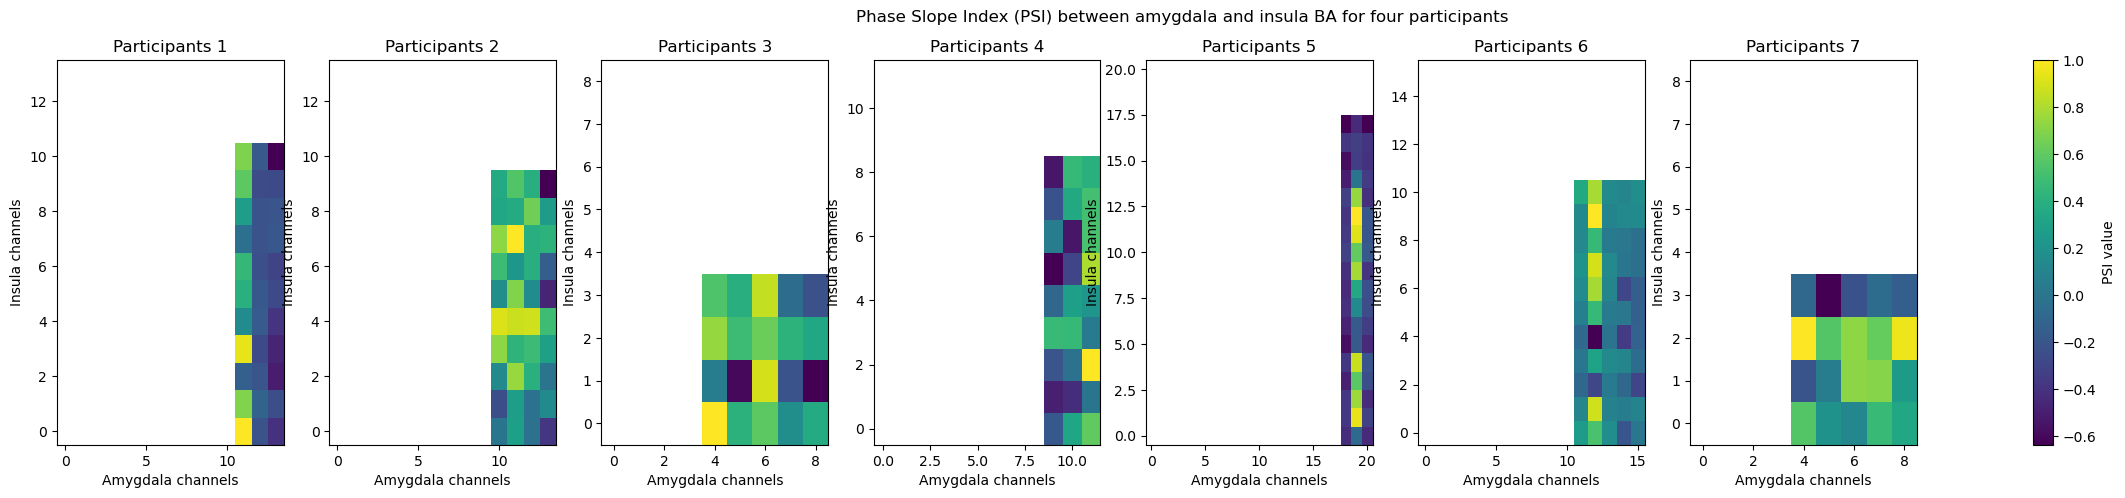

In [43]:
import numpy as np
from mne_connectivity import seed_target_indices, phase_slope_index
import matplotlib.pyplot as plt
import pickle

# 初始化一个列表来存储PSI值
psi_list = []

# 初始化一个列表来存储所有被试的PSI一维向量
all_psi_flat = []
# 初始化一个列表来存储所有被试的编码
subject_codes = []

# 设置可视化参数
fig, axes = plt.subplots(1, len(ROI1_pn), figsize=(30, 5))  # 创建一个包含3个子图的图

# 定义采样频率
sfreq = 1000  # 假设采样频率为 1000 Hz

# 循环处理每个被试的数据
for i in range(len(ROI1_pn)):

    # 创建被试编码
    subject_code = f'{i+1}'
    
    # 提取每个被试的TFR数据
    roi1_data = ROI1_pn[i][0].data
    roi2_data = ROI2_pn[i][0].data

    # 在axis=1维度上对频率进行平均
    roi1_averaged = np.mean(roi1_data, axis=1)  # 结果形状为 (channels, times)
    roi2_averaged = np.mean(roi2_data, axis=1)  # 结果形状为 (channels, times)

    # 合并平均后的数据
    combined_data = np.concatenate((roi1_averaged, roi2_averaged), axis=0)

    # 获取通道数量
    n_signals = combined_data.shape[0]
    n_signals_roi1 = roi1_averaged.shape[0]
    n_signals_roi2 = roi2_averaged.shape[0]

    # 创建索引对
    roi1_indices = np.arange(n_signals_roi1)
    roi2_indices = np.arange(n_signals_roi1, n_signals)
    indices = seed_target_indices(roi1_indices, roi2_indices)

    # 计算 PSI
    conn = phase_slope_index(
        combined_data[None, :, :],  # 添加一个新的维度表示试次数量，这里为 1
        indices=indices,
        sfreq=sfreq,
        fmin=50,
        fmax=150,
        mode='multitaper'
    )

    # 提取 PSI 矩阵
    psi = conn.get_data(output='dense')

    # 将三维PSI矩阵转换为二维
    psi_2d = np.squeeze(psi)

    # 将PSI矩阵添加到列表中
    psi_list.append(psi_2d)

    # psi 结果形状为 (n_signals_roi1, n_signals_roi2)
    #print(f"PSI shape for subject {i+1}: {psi_2d.shape}")

    # 保存PSI数据到CSV文件
    df = pd.DataFrame(psi_2d)
    csv_path = os.path.join(psi_out_path, f'psi_pn_subject_{i+1}.csv')
    df.to_csv(csv_path, index=False)

    # 将二维PSI矩阵展平成一维向量
    psi_flat = psi_2d.flatten()

    # 将PSI一维向量添加到总列表中
    all_psi_flat.extend(psi_flat.tolist())

    # 将被试编码添加到编码列表中
    subject_codes.extend([subject_code] * len(psi_flat))

    # psi 结果形状为 (n_signals_roi1 * n_signals_roi2,)
   # print(f"PSI vector shape for subject {i+1}: {psi_flat.shape}")
    
    # 在对应的子图中可视化 PSI 矩阵
    ax = axes[i]
    im = ax.imshow(psi_2d, aspect='auto', origin='lower', cmap='viridis')
    ax.set_title(f'Participants {i+1}')
    ax.set_xlabel('Amygdala channels')
    ax.set_ylabel('Insula channels')

# 添加颜色条
fig.colorbar(im, ax=axes.ravel().tolist(), label='PSI value')
fig.suptitle('Phase Slope Index (PSI) between amygdala and insula BA for four participants')
plt.show()

# 保存PSI值到文件
with open('psi_values.pkl', 'wb') as f:
    pickle.dump(psi_list, f)

#print("PSI values have been saved to 'psi_values.pkl'")

# 将所有被试的PSI一维向量和被试编码转换为DataFrame
all_psi_df_pn = pd.DataFrame({'PSI_att': all_psi_flat, 'Subject_Code': subject_codes})

# 删除包含缺失值的行
all_psi_df_pn.dropna(inplace=True)

# 保存所有被试的PSI一维向量和被试编码到CSV文件
all_csv_path = os.path.join(psi_out_path, 'all_psi_values_with_codes_pn.csv')
all_psi_df_pn.to_csv(all_csv_path, index=False)




### non-punish trials

Estimating phase slope index (PSI)
Connectivity computation...
    computing connectivity for 33 connections
    using t=0.000s..1.000s for estimation (1001 points)
    frequencies: 50.9Hz..149.9Hz (100 points)
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: Coherency
    computing cross-spectral density for epoch 1
[Connectivity computation done]
Computing PSI from estimated Coherency: <SpectralConnectivity | freq : [50.949051, 149.850150], , nave : 1, nodes, n_estimated : 14, 33, ~90 kB>
[PSI Estimation Done]
PSI shape for subject 1: (14, 14)
PSI vector shape for subject 1: (196,)
Estimating phase slope index (PSI)
Connectivity computation...
    computing connectivity for 40 connections
    using t=0.000s..1.000s for estimation (1001 points)
    frequencies: 50.9Hz..149.9Hz (100 points)
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: Coherency
    computing cross-spectra

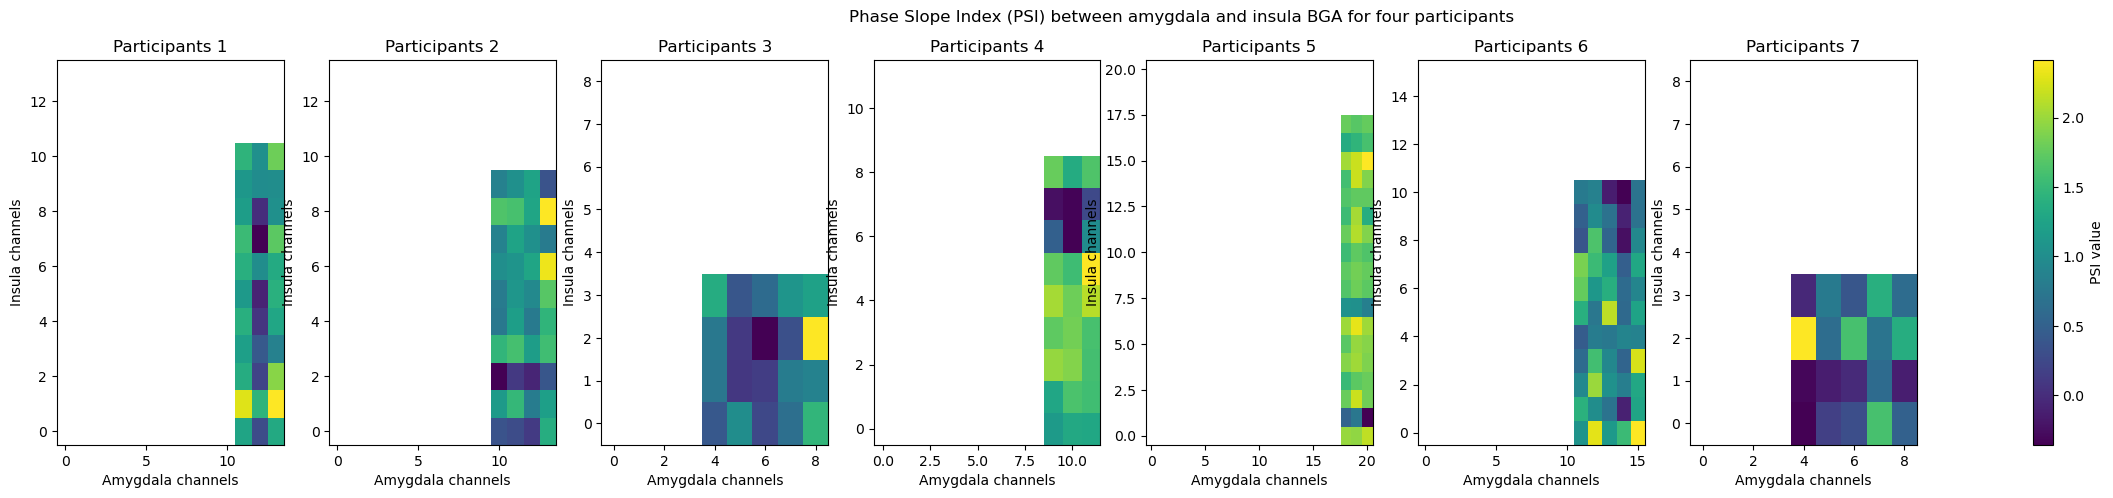

PSI values have been saved to 'psi_values.pkl'


In [44]:
import numpy as np
from mne_connectivity import seed_target_indices, phase_slope_index
import matplotlib.pyplot as plt
import pickle

# 初始化一个列表来存储PSI值
psi_list = []

# 初始化一个列表来存储所有被试的PSI一维向量
all_psi_flat = []
# 初始化一个列表来存储所有被试的编码
subject_codes = []

# 设置可视化参数
fig, axes = plt.subplots(1, len(ROI1_npn), figsize=(30, 5))  # 创建一个包含3个子图的图

# 定义采样频率
sfreq = 1000  # 假设采样频率为 1000 Hz

# 循环处理每个被试的数据
for i in range(len(ROI1_npn)):

    # 创建被试编码
    subject_code = f'{i+1}'
    
    # 提取每个被试的TFR数据
    roi1_data = ROI1_npn[i][0].data
    roi2_data = ROI2_npn[i][0].data

    # 在axis=1维度上对频率进行平均
    roi1_averaged = np.mean(roi1_data, axis=1)  # 结果形状为 (channels, times)
    roi2_averaged = np.mean(roi2_data, axis=1)  # 结果形状为 (channels, times)

    # 合并平均后的数据
    combined_data = np.concatenate((roi1_averaged, roi2_averaged), axis=0)

    # 获取通道数量
    n_signals = combined_data.shape[0]
    n_signals_roi1 = roi1_averaged.shape[0]
    n_signals_roi2 = roi2_averaged.shape[0]

    # 创建索引对
    roi1_indices = np.arange(n_signals_roi1)
    roi2_indices = np.arange(n_signals_roi1, n_signals)
    indices = seed_target_indices(roi1_indices, roi2_indices)

    # 计算 PSI
    conn = phase_slope_index(
        combined_data[None, :, :],  # 添加一个新的维度表示试次数量，这里为 1
        indices=indices,
        sfreq=sfreq,
        fmin=50,
        fmax=150,
        mode='multitaper'
    )

    # 提取 PSI 矩阵
    psi = conn.get_data(output='dense')

    # 将三维PSI矩阵转换为二维
    psi_2d = np.squeeze(psi)

    # 将PSI矩阵添加到列表中
    psi_list.append(psi_2d)

    # psi 结果形状为 (n_signals_roi1, n_signals_roi2)
    print(f"PSI shape for subject {i+1}: {psi_2d.shape}")

    # 保存PSI数据到CSV文件
    df = pd.DataFrame(psi_2d)
    csv_path = os.path.join(psi_out_path, f'psi_npn_subject_{i+1}.csv')
    df.to_csv(csv_path, index=False)

    # 将二维PSI矩阵展平成一维向量
    psi_flat = psi_2d.flatten()

    # 将PSI一维向量添加到总列表中
    all_psi_flat.extend(psi_flat.tolist())

    # 将被试编码添加到编码列表中
    subject_codes.extend([subject_code] * len(psi_flat))

    # psi 结果形状为 (n_signals_roi1 * n_signals_roi2,)
    print(f"PSI vector shape for subject {i+1}: {psi_flat.shape}")
    
    # 在对应的子图中可视化 PSI 矩阵
    ax = axes[i]
    im = ax.imshow(psi_2d, aspect='auto', origin='lower', cmap='viridis')
    ax.set_title(f'Participants {i+1}')
    ax.set_xlabel('Amygdala channels')
    ax.set_ylabel('Insula channels')

# 添加颜色条
fig.colorbar(im, ax=axes.ravel().tolist(), label='PSI value')
fig.suptitle('Phase Slope Index (PSI) between amygdala and insula BGA for four participants')
plt.show()

# 保存PSI值到文件
with open('psi_values.pkl', 'wb') as f:
    pickle.dump(psi_list, f)

print("PSI values have been saved to 'psi_values.pkl'")

# 将所有被试的PSI一维向量和被试编码转换为DataFrame
all_psi_df_npn = pd.DataFrame({'PSI_inatt': all_psi_flat, 'Subject_Code': subject_codes})

# 删除包含缺失值的行
all_psi_df_npn.dropna(inplace=True)

# 保存所有被试的PSI一维向量和被试编码到CSV文件
all_csv_path = os.path.join(psi_out_path, 'all_psi_values_with_codes_npn.csv')
all_psi_df_npn.to_csv(all_csv_path, index=False)

# 创建一个新的 DataFrame，直接将所需列合并
combined_df = pd.DataFrame({
    'PSI_inatt': all_psi_df_npn['PSI_inatt'],
    'Subject_Code': all_psi_df_npn['Subject_Code'],
    'PSI_att': all_psi_df_pn['PSI_att']
})

# 保存所有被试的PSI一维向量和被试编码到CSV文件
all_csv_path = os.path.join(psi_out_path, 'all_psi_values_with_codes.csv')
combined_df.to_csv(all_csv_path, index=False)

